## Equilibrium points of a linear ion chain

This notebook performs a classical calculation of the equilibrium positions of a chain of ions in an arbitrary 1D potential. This is a rather good approximation to the 3D equilibrium positions of the ions bound in a surface electrode trap.

First define a few physical constants to set up the problem.

In [95]:
from scipy.constants import e

axis_scale = 1e-6
ion_count = 40
ion_charge = e

Next import the potential data along the trapping axis.

In [96]:
import numpy as np
import scipy.interpolate
import yaml

data_dir = 'data/current_sim/'

# Import axis data
with open(data_dir + '/grid.txt') as f:
    grid = yaml.load(f)
x_ax = axis_scale * np.linspace(grid['starty'], grid['endy'], grid['dimy'])
x_len = (x_ax[-1] - x_ax[0]) / 2

# Import potential data
v_dat = np.loadtxt(data_dir + '/axis.txt')

The potential is fit to a polynomial and its derivative is calculated for evaluating the energy gradient.

In [97]:
from numpy.polynomial.polynomial import polyfit, Polynomial

# Fit to degree 6
v_pfit = polyfit(x_ax, v_dat, 6)
v = Polynomial(v_pfit)
v_grad = v.deriv()

The equilibrium positions will be found by minimizing total energy of the system as a function of the ion positions. The mathematical formula is the sum of the potential at each position and the Coulomb interaction of each particle pair:

$$\Phi(\mathbf x) = Q \sum_{i=1}^n V(x_i) + \frac{Q^2}{4 \pi \epsilon_0} \sum_{i=2}^n \sum_{j=1}^{i-1} \frac{1}{|x_i - x_j|}$$

where $Q$ is the ion charge, $V$ is the electric potential on the trap axis, and $\mathbf x \equiv (x_1, ..., x_n)$ is the ion position array.

In [98]:
from scipy.constants import pi, epsilon_0

coulomb_coef = ion_charge / (4 * pi * epsilon_0)

def phi(x):
    inverse_dist = [1 / abs(x[i] - x[j]) for i in range(1, len(x)) for j in range(i)]
    return ion_charge * (sum(v(x)) + coulomb_coef * sum(inverse_dist))

To improve the effectiveness of the optimizer, we analytically calculate the gradent of $\Phi$ using the polynomial expansion of the potential $V$. The mathematical formula for the gradient is:

$$(\nabla \Phi(\mathbf x))_k = Q V'(x_k) - \frac{Q^2}{4 \pi \epsilon_0} \sum_{\substack{j=1 \\ j\ne k}}^n \frac{x_k - x_j}{|x_k - x_j|^3}$$

In [99]:
def phi_grad(x):
    grad = np.zeros(len(x))
    for k in range(len(x)):
        inverse_dist = [cmp(x[k], x[j]) / (x[k] - x[j])**2 for j in range(k) + range(k + 1, len(x))]
        grad[k] = ion_charge * (v_grad(x[k]) - coulomb_coef * sum(inverse_dist))
    return grad

Now the data has to be "pre-conditioned" to make it suitable for running on the optimizer. The $x$-axis is normalized to the range $[-1, 1]$. The potential would ideally be normalized to make the gradient lie in a unit cube. Short of this, however, the energy will be normalized so the potential term lies roughly in $[-1, 1]$ as well.

In [100]:
vmax = ion_charge * abs(v_dat).max()
x_mid = (x_ax[-1] + x_ax[0]) / 2

def phi_n(x):
    return phi(x_len * x + x_mid) / vmax

def phi_grad_n(x):
    return x_len * phi_grad(x_len * x + x_mid) / vmax

Our initial guess $x_0$ is that the particles are uniformly along the middle half of the axis. This is fairly accurate for symmetric potentials.

In [101]:
x_0 = np.linspace(-0.5, 0.5, ion_count)

Finally, we call SciPy's optimization routine to minimize the energy. SciPy provides numerous algorithms to use in the [`scipy.optimize`](http://docs.scipy.org/doc/scipy/reference/optimize.html) module. Consider using the conjugate gradient or L-BFGS methods if you have fewer or more ions, respectively.

In [102]:
from scipy.optimize import fmin_bfgs

solution = fmin_bfgs(phi_n, x_0, fprime=phi_grad_n, gtol=1e-2)

print(solution)

Optimization terminated successfully.
         Current function value: 3.699682
         Iterations: 105
         Function evaluations: 175
         Gradient evaluations: 175
[-0.41881207 -0.43354351 -0.44840706 -0.46381892 -0.48042599 -0.49976878
 -0.48952855 -0.47192918 -0.4560354  -0.44092703 -0.42616803 -0.41138936
 -0.3804159  -0.40380749 -0.39620449 -0.37212928 -0.36343743 -0.38842196
 -0.34442737 -0.33357127 -0.32125625 -0.51206537 -0.35426045 -0.30577934
  0.18658314  0.21458682  0.25408943  0.23569676  0.2699019   0.29811439
  0.32379925  0.34837803  0.37318316  0.40062167  0.4171115   0.386437
  0.36058852  0.33616991  0.31116806  0.28452027]


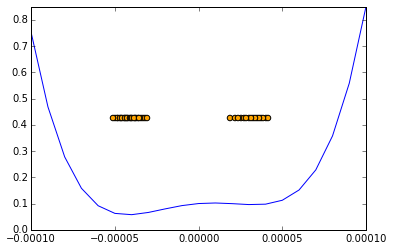

In [103]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(6, 4))
ax = fig.add_subplot(111)
ax.plot(x_ax, v_dat, 'b-')
#ax.set_xlim([-1, 1])
#ax.set_ylim([0, 1])
ax.set_ylim(0, vmax / ion_charge)
ax.set_xlim(-x_len, x_len)
[y0, y1] = ax.get_ylim()
ax.scatter(x_len * solution, [(y0 + y1) / 2] * len(x_0), c='orange', s=30)

A significant time and resource improvement could potentially be by assuming the potential, and therefore equilibrium positions, are symmetric about the trap center. Performance has not been a concern yet, so we ignore this option.